In [17]:
import os
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
from nltk.tokenize import RegexpTokenizer

import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

from model import EncDecNet, VGG16, RNN_ENCODER
#from main import get_imgs

from PIL import Image


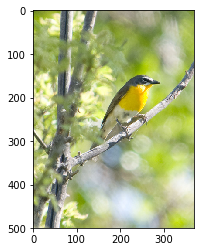

In [2]:
path = '/data/unagi0/ktokitake/encdecmodel/birds/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0023_21664.jpg'
#path = '%s/%s' %  (data_dir, 'CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0023_21664.jpg ')
#path = '/data/unagi0/ktokitake/encdecmodel/birds/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0023_21664.jpg '
img = Image.open(path).convert('RGB')
plt.imshow(img)

In [3]:
data_dir = '/data/unagi0/ktokitake/encdecmodel/birds'
pkl_path = os.path.join(data_dir, 'captions.pickle')
with open(pkl_path, 'rb') as f:
    x = pkl.load(f)
ixtoword, wordtoix = x[2], x[3]

In [4]:
imsize = [64, 128, 256]
image_transform = transforms.Compose([
        transforms.Scale(int(imsize[-1] * 76 / 64))])          
norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


In [5]:
netG_path = 'birds_EncDecModel_2021_01_06_22_17_09'
if os.path.exists('/data/unagi0/ktokitake/encdecmodel/birds/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0023_21664.jpg'):
    print('yes')
else:
    print('no')
    

yes


In [16]:

def get_imgs(img_path, imsize, flip, x, y, bbox=None,
             transform=None, normalize=None):
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)
        img = img.crop([x1, y1, x2, y2])

    if transform is not None:
        img = transform(img)
        ## crop
        img = img.crop([x, y, x + 256, y + 256])
       # if flip:
        #    img = F.hflip(img)

    ret = []
    for i in range(3):
        if i < (3 - 1):
            re_img = transforms.Scale(imsize[i])(img)
        else:
            re_img = img
        ret.append(normalize(re_img))

    return ret

In [18]:
### prepare data
text1 = 'a very colorful bird with a blue head, yellow back and orange belly.'
text2 = ''
sentences = [text1] ## sentences は一つであることを仮定
captions = []
cap_lens = []
for sent in sentences:
    if len(sent) == 0:
        continue
    sent = sent.replace("\ufffd\ufffd", " ")
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sent.lower())
    if len(tokens) == 0:
        print('sent', sent)
        continue

    rev = []
    for t in tokens:
        t = t.encode('ascii', 'ignore').decode('ascii')
        if len(t) > 0 and t in wordtoix:
            rev.append(wordtoix[t])
    captions.append(rev)
    cap_lens.append(len(rev))

max_len = cap_lens[0]
cap_array = np.zeros((len(captions), max_len), dtype='int64')
cap_array[0, :max_len] = captions[0]
cap_lens = np.asarray(cap_lens)
print('load text data')


### from_img
from_img_name = 'CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0023_21664.jpg '
img_path = '/data/unagi0/ktokitake/encdecmodel/birds/CUB_200_2011/images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0023_21664.jpg'
flip = random.rand() > 0.5
new_w = new_h = int(256 * 76 / 64)
x = random.randint(0, np.maximum(0, new_w - 256))
y = random.randint(0, np.maximum(0, new_h - 256))
#img_path = '%s/%s' % (data_dir, from_img_name)
#img_path = os.path.join(data_dir, from_img_name)
from_imgs = get_imgs(img_path, imsize, flip, x, y,
                None, image_transform, norm)
print('load from img')


### to_img
to_img_name = 'CUB_200_2011/images/015.Lazuli_Bunting/Lazuli_Bunting_0020_14837.jpg '
flip = random.rand() > 0.5
new_w = new_h = int(256 * 76 / 64)
x = random.randint(0, np.maximum(0, new_w - 256))
y = random.randint(0, np.maximum(0, new_h - 256))
#img_path = '%s/%s' % (data_dir, to_img_name)
img_path ='/data/unagi0/ktokitake/encdecmodel/birds/CUB_200_2011/images/015.Lazuli_Bunting/Lazuli_Bunting_0027_14895.jpg'


to_imgs = get_imgs(img_path, imsize, flip, x, y,
                None, image_transform, norm)

print('load to img')

load text data
load from img
load to img


In [7]:
### define models ###
n_words = len(ixtoword)
n_hidden = 256
train_netE_path = '../DAMSMencoders/bird/text_encoder.pth'
text_encoder = \
        RNN_ENCODER(n_words, nhidden=n_hidden)
state_dict = \
        torch.load(train_netE_path, map_location=lambda storage, loc: storage)
text_encoder.load_state_dict(state_dict)
print('Load text encoder from:', train_netE_path)
text_encoder = text_encoder.cuda()
text_encoder.eval()

VGG = VGG16()
print("Load the VGG model")
VGG.cuda()
VGG.eval()


netG = EncDecNet()
model_dir = os.path.join(data_dir, 'output', netG_path, 'Model/netG_epoch_600.pth')
state_dict = \
        torch.load(model_dir, map_location=lambda storage, loc: storage)
netG.load_state_dict(state_dict)
print('Load G from: ', model_dir)
#netG = nn.DataParallel(netG, device_ids= self.gpus)
netG.cuda()
netG.eval()

Load text encoder from: ../DAMSMencoders/bird/text_encoder.pth
Load the VGG model
Load G from:  /data/unagi0/ktokitake/encdecmodel/birds/output/birds_EncDecModel_2021_01_06_22_17_09/Model/netG_epoch_600.pth


EncDecNet(
  (canet): CA_NET(
    (fc): Linear(in_features=256, out_features=400, bias=True)
    (relu): GLU()
  )
  (dec_net): DecNet(
    (upsample1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=nearest)
      (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): GLU()
    )
    (upsample2): Sequential(
      (0): Upsample(scale_factor=2.0, mode=nearest)
      (1): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): GLU()
    )
    (upsample3): Sequential(
      (0): Upsample(scale_factor=2.0, mode=nearest)
      (1): Conv2d(384, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): 

In [19]:
captions = Variable(torch.from_numpy(cap_array), volatile=True)
cap_lens = Variable(torch.from_numpy(cap_lens), volatile=True)
captions = captions.cuda()
cap_lens = cap_lens.cuda()

batch_size = captions.shape[0]
nz = 100
noise = Variable(torch.FloatTensor(batch_size, nz), volatile=True)
noise = noise.cuda()

hidden = text_encoder.init_hidden(batch_size)

words_embs, sent_emb = text_encoder(captions, cap_lens, hidden)
words_embs, sent_emb = words_embs.detach(), sent_emb.detach()

mask = (captions == 0)

noise.data.normal_(0, 1)

from_imgs_cuda= [] 
to_imgs_cuda = []
for i in range(len(from_imgs)):
    from_imgs_cuda.append(from_imgs[i].cuda())    
    to_imgs_cuda.append(to_imgs[i].cuda())

In [23]:
enc_features_from = VGG(from_imgs_cuda[-1].unsqueeze(0))
enc_features_to = VGG(to_imgs_cuda[-1].unsqueeze(0))
split_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
fake_imgs = []
for i in range(len(split_list)):
    split_rate = split_list[i]
    new_enc_features = []
    for j in range(len(enc_features_from)):
        now_enc = enc_features_from[j]*(1-split_rate) + enc_features_to[j]*split_rate
        new_enc_features.append(now_enc)
    fake_img, _,_ = netG(from_imgs[-1], sent_emb, words_embs, noise, mask, new_enc_features)
    fake_imgs.append(fake_img)

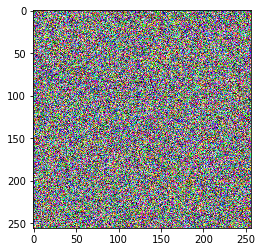

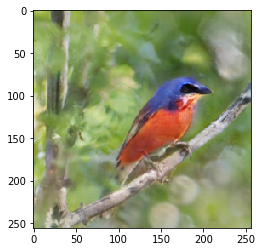

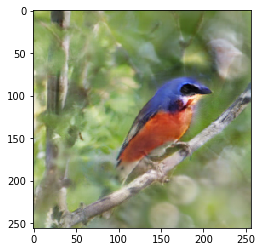

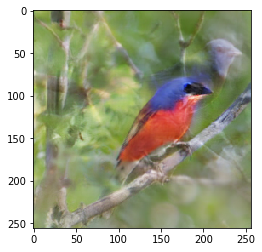

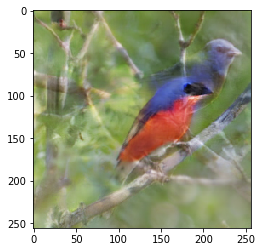

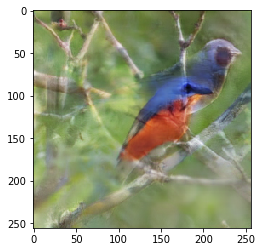

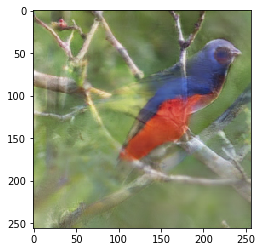

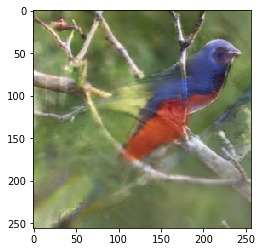

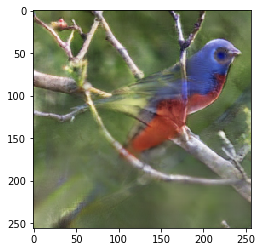

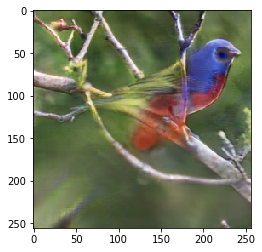

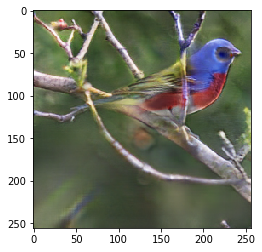

In [25]:
new_fake_imgs = []
for i in range(len(fake_imgs)):
    fake_im = fake_imgs[i]
    fake_im.add_(1).div_(2).mul_(255)
    fake_im = fake_im.squeeze()
    fake_im = fake_im.detach().cpu().numpy()
    fake_im = np.transpose(fake_im, (1,2,0)).astype(np.uint8)
    #new_fake_imgs.append(fake_im)
#new_fake_imgs_np = np.concatenate(new_fake_imgs, axis=1)
    fake_im = Image.fromarray(fake_im)
    plt.figure()
    plt.imshow(fake_im)
    
    